In [ ]:
#Download Requried Module
!python3 -m pip install yfinance
!python3 -m pip install torch torchvision torchaudio
!python3 -m pip install transformers
!python3 -m pip install finnhub-python

#Import Required Modules
import math
import yfinance as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re
import finnhub
from datetime import datetime, timedelta
plt.style.use("fivethirtyeight")

# Pandas for Data manipulation
import pandas as pd
#Numpy for Data Manipulation
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 8.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
#Retrieve Name of Stock and Start Date
stockName = input("What Is The Name Of The Stock? ")
#Create Pandas DataFrame
StockData = web.download(stockName, end = datetime.now().strftime("%Y-%m-%d"))
#Display Pandas DataFrame
print(StockData)

What Is The Name Of The Stock? TSLA
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-06-29    1.266667    1.666667    1.169333    1.592667    1.592667   
2010-06-30    1.719333    2.028000    1.553333    1.588667    1.588667   
2010-07-01    1.666667    1.728000    1.351333    1.464000    1.464000   
2010-07-02    1.533333    1.540000    1.247333    1.280000    1.280000   
2010-07-06    1.333333    1.333333    1.055333    1.074000    1.074000   
...                ...         ...         ...         ...         ...   
2023-02-13  194.419998  196.300003  187.610001  194.639999  194.639999   
2023-02-14  191.940002  209.820007  189.440002  209.250000  209.250000   
2023-02-15  211.759995  214.660004  206.110001  214.240005  214.240005   
2023-02-16  210.779999  217.649994  201.839996  202.039993  202.039993   
2023-02

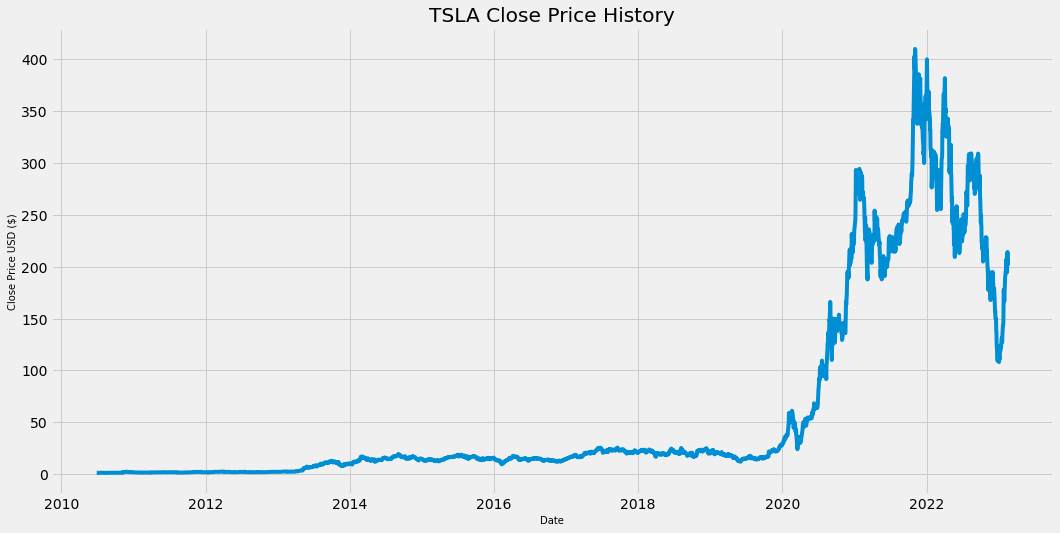

In [ ]:
#Get The Number of Rows and Columns
StockData.shape

#Visualize The Closing Price History
plt.figure(figsize = (16, 8))
plt.title(f"{stockName} Close Price History")
plt.plot(StockData["Close"])
plt.xlabel("Date", fontsize = 10)
plt.ylabel("Close Price USD ($)", fontsize = 10)
plt.show()

In [ ]:
#Create A New DataFrame with Only the Close Value
CloseData = StockData.filter(["Close"])

#Convert Dataframe To NumPy Values
CloseDataSet = CloseData.values

In [ ]:
#Scale The Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaledData = scaler.fit_transform(CloseDataSet)

In [ ]:
#Create The Training Data Set

#Create The Scaled Training Data Set
TrainingData = scaledData

#Split the Data Into X_Train and y_Train Data Sets
X_Train = []
y_Train = []

for i in range(60, len(TrainingData)):
  X_Train.append(TrainingData[i-60:i])
  y_Train.append(TrainingData[i])

In [ ]:
#Convert the X_Train and y_Train to NumPy Arrays
X_Train, y_Train = np.array(X_Train), np.array(y_Train)

#Reshape The Data
X_Train = np.reshape(X_Train, (X_Train.shape[0], X_Train.shape[1], 1))
X_Train.shape

(3123, 60, 1)

In [ ]:
#Build the LSTM Model
model = Sequential()
model.add(LSTM(25, return_sequences = True, input_shape = (X_Train.shape[1], 1)))
model.add(LSTM(25, return_sequences = False))
model.add(Dense(5))
model.add(Dense(1))

In [ ]:
#Compile The Model
#Optimizer: Used To Improve Upon The Loss Function
#Loss: Used to Measure How Well The Model Performs
model.compile(optimizer = "adam", loss = "mean_squared_error")

In [ ]:
#Train The Model
#Batch Size: Total Number of Training Examples Present In A Single Batch
#Epochs: The Number of Iterations For A Dataset To Be Passed Forward and Backwards
model.fit(X_Train, y_Train, batch_size = 1, epochs = 3)

Epoch 1/3
3123/3123 [==============================] - 43s 10ms/step - loss: 0.0014
Epoch 2/3
3123/3123 [==============================] - 25s 8ms/step - loss: 5.1019e-04
Epoch 3/3
3123/3123 [==============================] - 26s 8ms/step - loss: 3.9820e-04


In [ ]:
#Gather Past Year Worth of Data
startDate = datetime.now() - timedelta(days = 365)
TestData = web.download(stockName, start = startDate.strftime("%Y-%m-%d"), end = datetime.now().strftime("%Y-%m-%d"))

#Filter Data to Last 60 Closing Values
CloseTestData = TestData.filter(["Close"])
CloseTestData = np.array(scaler.fit_transform(CloseTestData.values))[-60:]

#Reshape Data For Predictions
X_Test = np.reshape(CloseTestData, (1, 60, 1))

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Model's Predicted Price Values
predictions = model.predict(X_Test)
predictions = scaler.inverse_transform(predictions)
print(predictions)

1/1 [==============================] - 1s 694ms/step
[[212.98157]]


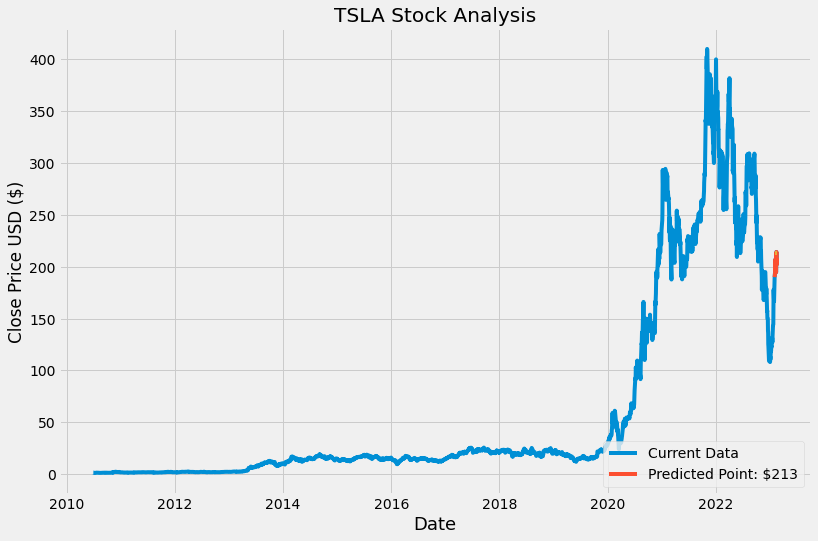

In [ ]:
#Plot The Data
Data = CloseData.copy()
predictedDataX = datetime.now() + timedelta(days = 1)
predictedDataX = predictedDataX.strftime("%Y-%m-%d")
estimatedClosingPrice = predictions[0][0]

#Visualize The Data
currentDay = datetime.now()
plt.figure(figsize = (12, 8))
plt.title(f"{stockName} Stock Analysis")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD ($)")
plt.plot(Data)
Data[predictedDataX] = estimatedClosingPrice
plt.plot(Data[-11:])
plt.legend(["Current Data", f"Predicted Point: ${round(estimatedClosingPrice)}"], loc = "lower right")
plt.show()

In [ ]:
#Web Scrape Top 10 Headlines From Yahoo Finance

#Retrieve URL for Reponse Variable
my_url = f"http://finance.yahoo.com/quote/{stockName}?p={stockName}"
response = requests.get(my_url)

#Catching Exceptions
print(f"response.ok : {response.ok}, response.status_code : {response.status_code}")
print("Preview of response.text : ", response.text[:500])

#Download Webpage and Return a Beautiful Soup Doc
def get_page(url):
  response = requests.get(url)
  if not response.ok:
    print('Status code:', response.status_code)
    raise Exception(f'Failed to load page {url}')
  else: 
    page_content = response.text
    doc = BeautifulSoup(page_content, 'html.parser')
    return doc

stockDoc = get_page(my_url)
stockATags = stockDoc.find_all("a", {'class': "js-content-viewer"})
stockHeadlines = []
for i in range(0, 10): 
  stockHeadlines.append(stockATags[i].text)

marketDoc = get_page("https://ca.finance.yahoo.com/topic/news/")
marketATags = marketDoc.find_all("a", {"class": "js-content-viewer"})
marketHeadlines = []
for i in range(0, 10):
  marketHeadlines.append(marketATags[i].text)

response.ok : True, response.status_code : 200
Preview of response.text :  <!doctype html><html data-color-theme="light" id="atomic" class="NoJs chrome desktop failsafe" lang="en-US"><head prefix="og: https://ogp.me/ns#"><script>window.performance && window.performance.mark && window.performance.mark('PageStart');</script><meta charset="utf-8"><title>Tesla, Inc. (TSLA) Stock Price, News, Quote &amp; History - Yahoo Finance</title><meta name="keywords" content="TSLA, Tesla, Inc., TSLA stock chart, Tesla, Inc. stock chart, stock chart, stocks, quotes, finance"><meta http


In [ ]:
#Get Top 10 Headlines From Finnhub API
#Initiate Finnhub API
APIKey = input("Enter Your API KEY: ")
fh = finnhub.Client(api_key=APIKey)

#Retrieve Company News
startDate = datetime.now() - timedelta(days = 7)
startDate = startDate.strftime("%Y-%m-%d")
endDate = datetime.now()
endDate = endDate.strftime("%Y-%m-%d")

stockNews = fh.company_news(stockName, _from=startDate, to=endDate)
stockNewsSummary = []

#Retrieve Market News
marketNews = fh.general_news("general")
marketNewsSummary = []

#Add to Yahoo Finance Data for Sentiment Analysis
for i in range(0, 10): 
  stockHeadlines.append(stockNews[i]["headline"])
  marketHeadlines.append(marketNews[i]["headline"])
  stockNewsSummary.append(stockNews[i]["summary"])
  marketNewsSummary.append(marketNews[i]["summary"])

Enter Your API KEY: cfp95s1r01qq927hcgsgcfp95s1r01qq927hcgt0


In [ ]:
#Instantiate Model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

#Encode and Calculate Sentiment
def calculateSentiment(statement): 
  token = tokenizer.encode(statement, return_tensors = "pt")
  result = model(token)
  return int(torch.argmax(result.logits)) + 1

#Calculate Stock Headline Sentiment

def calculateSentimentOf(topic):
  sentiment = 0 
  for statement in topic: 
    sentiment = sentiment + calculateSentiment(statement)
  return sentiment / (len(topic))

stockHeadlineSentiment = calculateSentimentOf(stockHeadlines)
stockNewsSummarySentiment = calculateSentimentOf(stockNewsSummary)
marketHeadlineSentiment = calculateSentimentOf(marketHeadlines)
marketNewsSummarySentiment = calculateSentimentOf(marketNewsSummary)
finalSentiment = ((stockHeadlineSentiment + stockNewsSummarySentiment) / 2 * 0.8 + (marketHeadlineSentiment + marketNewsSummarySentiment) / 2 * 0.2)

In [ ]:
#Find Amount of Recommendations To Either Buy or Sell Stock
recommendedBuy = fh.recommendation_trends(stockName)[0]["buy"] + fh.recommendation_trends(stockName)[0]["strongBuy"]
recommendedSell = fh.recommendation_trends(stockName)[0]["hold"] + fh.recommendation_trends(stockName)[0]["sell"] + fh.recommendation_trends(stockName)[0]["strongSell"]

In [ ]:
#Final Verdict - Final Sentiment, Estimated Closing Price, Recommmendation
if finalSentiment < 1: 
  print(f"Based On Current News Regarding {stockName} and the Stock Market; It's DEFINITELY Not A Good Time To Purchase The Stock")
elif finalSentiment > 1.00 and finalSentiment < 2.00: 
  print(f"Based On Current News Regarding {stockName} and the Stock Market; It's MOST LIKELY Not A Good Time To Purchase The Stock")
elif finalSentiment > 2.00 and finalSentiment < 3.00:
  print(f"Based On Current News Regarding {stockName} and the Stock Market; It MAY Not Be A Good Time To Purchase The Stock")
elif finalSentiment > 3.00 and finalSentiment < 4.00: 
  print(f"Based On Current News Regarding {stockName} and the Stock Market; It's MOST LIKELY A Good Time To Purchase The Stock")
elif finalSentiment > 4.00: 
  print(f"Based On Current News Regarding {stockName} and the Stock Market; It's DEFINITELY A Good Time To Purchase The Stock")

closingPrice = CloseData["Close"][-1]
if closingPrice > estimatedClosingPrice: 
  print(f"Based On The Predicted Value Of The Next Closing Price of {stockName}, It's Maybe Not A Wise Decision To Purchase The Stock")
else: 
  print(f"Based On The Predicted Value Of The Next Closing Price of {stockName}, It's Maybe A Wise Decision To Purchase The Stock")

print(f"Recommendations From Analysts: {recommendedBuy} Analysts Recommended to Buy {stockName} and {recommendedSell} Analysts Recommended to Sell {stockName}")

Based On Current News Regarding TSLA and the Stock Market; It MAY Not Be A Good Time To Purchase The Stock
Based On The Predicted Value Of The Next Closing Price of TSLA, It's Maybe A Wise Decision To Purchase The Stock
Recommendations From Analysts: 31 Analysts Recommended to Buy TSLA and 17 Analysts Recommended to Sell TSLA
